# REMOVE BACKGROUND

In [ ]:
from PIL import Image
import os

def remove_white_background(input_path, output_path, compression_quality=85):
    # Open the image
    image = Image.open(input_path)

    # Convert the image to RGBA (if it's not already)
    image = image.convert('RGBA')

    # Get data of the image
    data = image.getdata()

    # Define a threshold to identify the white background
    threshold = 255
    new_data = []
    for item in data:
        # Set the pixel to transparent if it's white
        if item[0] > threshold and item[1] > threshold and item[2] > threshold:
            new_data.append((255, 255, 255, 0))  # White becomes transparent
        else:
            new_data.append(item)

    # Update the image data
    image.putdata(new_data)

    # Convert the image to RGB before saving as JPEG
    rgb_image = image.convert('RGB')

    # Save the result with compression
    rgb_image.save(output_path, quality=compression_quality)

# Dataset path
ds_path = r"dataset/images"

# Count the number of subfolders in the dataset path to determine the number of classes
class_folders = [f for f in os.listdir(ds_path) if os.path.isdir(os.path.join(ds_path, f))]
num_classes = len(class_folders)

print("Number of Classes: ", num_classes)
print("Classes: ", class_folders)

types = 0

for folder in class_folders:
    disease_folder = os.path.join(ds_path, folder)

    print('Processing images in folder: ', folder)

    # Create a folder for the processed images if it doesn't exist
    output_folder = os.path.join('dataset/other images', f"{folder}_processed")
    os.makedirs(output_folder, exist_ok=True)

    for image_name in os.listdir(disease_folder):
        input_image_path = os.path.join(disease_folder, image_name)
        output_image_path = os.path.join(output_folder, image_name)

        # Call the function to remove the white background and compress the image
        remove_white_background(input_image_path, output_image_path)


# EDI-FEATURES


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops

In [2]:
ds_path = r"dataset/images"
diseases= os.listdir(ds_path)

In [3]:
diseases

['Brown Spot', 'Healthy', 'Hispa', 'Leaf Blast']

In [4]:
from skimage import exposure
from skimage.feature import hog
from skimage.measure import regionprops
from scipy import stats
from skimage.measure import label

# Set the dataset path
ds_path = r"dataset/images"

def features():
    names = ['area', 'perimeter', 'physiological_length', 'physiological_width', 'aspect_ratio',
             'mean_r', 'mean_g', 'mean_b', 'stddev_r', 'stddev_g', 'stddev_b',
             'contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity',
             'eccentricity', 'solidity', 'equiv_diameter', 'major_axis_length', 'minor_axis_length',
             'skewness', 'kurtosis', 'hog_feature_1', 'hog_feature_2', 'hog_feature_3', 'types'
            ]
    df = pd.DataFrame(columns=names)

    # Count the number of subfolders in the dataset path to determine the number of classes (labels)
    class_folders = [f for f in os.listdir(ds_path) if os.path.isdir(os.path.join(ds_path, f))]
    num_classes = len(class_folders)

    print("Number of Classes: ", num_classes)
    print("Classes: ", class_folders)

    types = 0

    for folder in class_folders:
        disease_folder = os.path.join(ds_path, folder)

        print('Extracting features in folder: ', folder)
        types = folder
        index = 0
        
        for image in os.listdir(disease_folder):
            index = index + 1
            print('Extracting features in image: ', index, 'Image: ', image)
            imgpath = os.path.join(disease_folder, image)
            main_img = cv2.imread(imgpath)

            # Preprocessing
            img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
            gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            blur = cv2.GaussianBlur(gs, (25, 25), 0)
            ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            kernel = np.ones((50, 50), np.uint8)
            closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

            # Shape features
            contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cnt = contours[0]
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = float(w) / h

            # Color features
            red_channel = img[:, :, 0]
            green_channel = img[:, :, 1]
            blue_channel = img[:, :, 2]

            red_mean = np.mean(red_channel)
            green_mean = np.mean(green_channel)
            blue_mean = np.mean(blue_channel)

            # Std deviation
            red_std = np.std(red_channel)
            green_std = np.std(green_channel)
            blue_std = np.std(blue_channel)

            # Texture features using GLCM matrix
            glcm = graycomatrix(gs,
                                distances=[1],
                                angles=[0],
                                symmetric=True,
                                normed=True)

            properties = ['contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity']
            contrast = graycoprops(glcm, properties[0])
            energy = graycoprops(glcm, properties[1])
            homogeneity = graycoprops(glcm, properties[2])
            correlation = graycoprops(glcm, properties[3])
            dissimilarity = graycoprops(glcm, properties[4])

            # Statistical moments
            skewness = stats.skew(gs.flatten())
            kurtosis = stats.kurtosis(gs.flatten())

            # Additional features
            labeled_img = label(closing)
            regions = regionprops(labeled_img)

            eccentricity = regions[0].eccentricity
            solidity = regions[0].solidity
            equiv_diameter = regions[0].equivalent_diameter
            major_axis_length = regions[0].major_axis_length
            minor_axis_length = regions[0].minor_axis_length

            # HOG features
            hog_features = hog(gs, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2-Hys')

            vector = [area, perimeter, w, h, aspect_ratio,
                      red_mean, green_mean, blue_mean, red_std, green_std, blue_std,
                      contrast[0][0], energy[0][0], homogeneity[0][0], correlation[0][0], dissimilarity[0][0],
                      eccentricity, solidity, equiv_diameter, major_axis_length, minor_axis_length,
                      skewness, kurtosis, hog_features[0], hog_features[1], hog_features[2], types]

            df_temp = pd.DataFrame([vector], columns=names)
            df = pd.concat([df, df_temp], ignore_index=True)
    return df

In [5]:
# Call the function to create the feature dataframe
feature_df = features()

# Save the resulting dataframe to a CSV file
feature_df.to_csv("dataset/csv/image_features.csv", index=False)

Number of Classes:  4
Classes:  ['Brown Spot', 'Healthy', 'Hispa', 'Leaf Blast']
Extracting features in folder:  Brown Spot
Extracting features in image:  1 Image:  IMG_20190420_191213.jpg
Extracting features in image:  2 Image:  IMG_20190420_191216.jpg
Extracting features in image:  3 Image:  IMG_20190420_191238.jpg
Extracting features in image:  4 Image:  IMG_20190420_191242.jpg
Extracting features in image:  5 Image:  IMG_20190420_191412.jpg
Extracting features in image:  6 Image:  IMG_20190420_191416.jpg
Extracting features in image:  7 Image:  IMG_20190420_193225.jpg
Extracting features in image:  8 Image:  IMG_20190420_193236.jpg
Extracting features in image:  9 Image:  IMG_20190420_193433.jpg
Extracting features in image:  10 Image:  IMG_20190420_194201.jpg
Extracting features in image:  11 Image:  IMG_20190420_194202.jpg
Extracting features in image:  12 Image:  IMG_20190420_194203.jpg
Extracting features in image:  13 Image:  IMG_20190420_194204.jpg
Extracting features in imag

In [6]:
feature_df.head()

,area,perimeter,physiological_length,physiological_width,aspect_ratio,mean_r,mean_g,mean_b,stddev_r,stddev_g,...,solidity,equiv_diameter,major_axis_length,minor_axis_length,skewness,kurtosis,hog_feature_1,hog_feature_2,hog_feature_3,types
0,1972073.5,9628.785713,3120,2225,1.402247,195.258556,193.313269,173.783708,57.834578,54.947868,...,0.742358,1586.292032,4060.844957,729.870542,-1.349515,0.361069,0.449522,0.181592,0.163116,Brown Spot
1,38825.0,1042.225395,309,193,1.601036,200.541047,198.177794,178.330766,57.300307,54.351389,...,0.985009,1528.054134,3892.425283,627.943954,-1.381121,0.468266,0.363637,0.363637,0.363637,Brown Spot
2,16776.0,799.740114,214,184,1.163043,193.216871,193.351267,174.504667,54.261332,50.802715,...,0.966643,1482.078679,3807.992148,599.773878,-1.463399,0.792236,0.409428,0.160951,0.361947,Brown Spot
3,1296182.5,6467.057458,2324,1432,1.622905,187.503883,187.446881,163.931188,60.086385,55.726472,...,0.983399,1286.079530,2852.383343,604.509849,-1.172834,-0.234045,0.419914,0.275145,0.419914,Brown Spot
4,921537.0,5424.236169,1403,1860,0.754301,185.310038,184.469700,162.667911,62.826548,60.994339,...,0.979396,1084.572557,2403.186888,507.503272,-1.141764,-0.336749,0.378794,0.361990,0.378794,Brown Spot


# PCA

## Components

In [7]:
import pandas as pd
from sklearn.decomposition import PCA

In [8]:
df = pd.read_csv("dataset/csv/image_features.csv")

In [9]:
# Assuming df is your DataFrame with the features
X = df.drop('types', axis=1)
pca = PCA()
X_pca = pca.fit_transform(X)

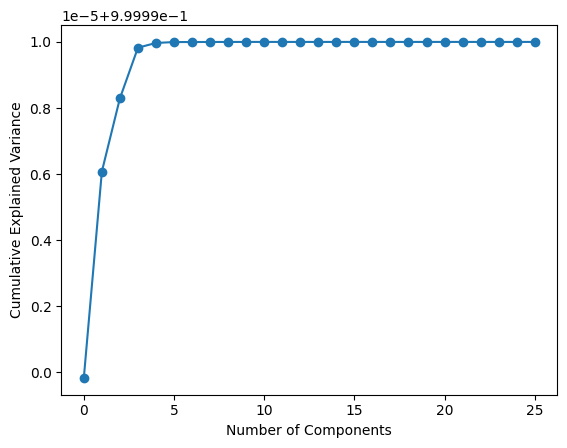

In [10]:
import matplotlib.pyplot as plt

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

## Training

In [11]:
import pandas as pd

In [12]:
data=pd.read_csv("dataset/csv/image_features.csv")

In [13]:
types = data["types"]

In [14]:
types_labels = types.unique()
types_labels

array(['Brown Spot', 'Healthy', 'Hispa', 'Leaf Blast'], dtype=object)

In [15]:
data = data.drop('types', axis=1)

In [16]:
data.head()

,area,perimeter,physiological_length,physiological_width,aspect_ratio,mean_r,mean_g,mean_b,stddev_r,stddev_g,...,eccentricity,solidity,equiv_diameter,major_axis_length,minor_axis_length,skewness,kurtosis,hog_feature_1,hog_feature_2,hog_feature_3
0,1972073.5,9628.785713,3120,2225,1.402247,195.258556,193.313269,173.783708,57.834578,54.947868,...,0.983715,0.742358,1586.292032,4060.844957,729.870542,-1.349515,0.361069,0.449522,0.181592,0.163116
1,38825.0,1042.225395,309,193,1.601036,200.541047,198.177794,178.330766,57.300307,54.351389,...,0.986901,0.985009,1528.054134,3892.425283,627.943954,-1.381121,0.468266,0.363637,0.363637,0.363637
2,16776.0,799.740114,214,184,1.163043,193.216871,193.351267,174.504667,54.261332,50.802715,...,0.987518,0.966643,1482.078679,3807.992148,599.773878,-1.463399,0.792236,0.409428,0.160951,0.361947
3,1296182.5,6467.057458,2324,1432,1.622905,187.503883,187.446881,163.931188,60.086385,55.726472,...,0.977285,0.983399,1286.079530,2852.383343,604.509849,-1.172834,-0.234045,0.419914,0.275145,0.419914
4,921537.0,5424.236169,1403,1860,0.754301,185.310038,184.469700,162.667911,62.826548,60.994339,...,0.977447,0.979396,1084.572557,2403.186888,507.503272,-1.141764,-0.336749,0.378794,0.361990,0.378794


In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 14)
pca.fit(data)

PCA(n_components=14)

In [18]:
# Access the loadings of the first three principal components
loadings = pca.components_[:14]

# Map the loadings to the original feature names
original_feature_names = data.columns
component_loadings = pd.DataFrame(loadings, columns=original_feature_names)

# Display the loadings for the first three components
print(component_loadings)

            area  perimeter  physiological_length  physiological_width  \
0   9.999918e-01   0.003534              0.001221             0.000913   
1  -3.799398e-03   0.840445              0.118561             0.451325   
2   1.108554e-03  -0.213030             -0.779668             0.586497   
3  -3.409249e-04  -0.218795              0.019124            -0.124507   
4  -2.462379e-04   0.437170             -0.609917            -0.656341   
5   7.661427e-04  -0.091828             -0.065463            -0.067600   
6   2.577330e-05   0.000528             -0.005235            -0.011998   
7   7.633605e-05  -0.017723              0.005644             0.003868   
8   3.023410e-06   0.021092             -0.032612            -0.031278   
9  -1.636576e-05  -0.002702              0.010349             0.008421   
10  3.547625e-06   0.007722             -0.012116            -0.015384   
11 -2.287367e-06   0.002681             -0.004945            -0.003532   
12 -2.481290e-06  -0.000845           

In [19]:
data2=pca.transform(data)

In [20]:
data2

array([[ 1.16988114e+06, -1.47769056e+02, -4.26613834e+02, ...,
        -6.84443188e+00, -1.90131547e+00,  1.10695423e+00],
       [-7.63387352e+05, -1.30518598e+03,  2.49222141e+02, ...,
        -4.38505829e+00,  2.00136999e-01, -6.21796237e-01],
       [-7.85437278e+05, -1.45940407e+03,  3.40182716e+02, ...,
        -4.36461854e+00,  1.63385983e+00,  4.75903691e-01],
       ...,
       [-5.14549431e+05, -4.78264603e+02, -3.05151715e+02, ...,
        -2.86686409e+00, -1.37082036e+00, -4.63447791e-01],
       [-3.79466279e+05,  4.76350585e+02, -1.33382644e+02, ...,
        -3.01783769e+00, -8.23883614e-01, -7.77732959e-01],
       [-2.59317758e+05, -5.42959720e+02, -5.87652204e+01, ...,
         1.52017057e+01,  2.71337463e+00,  2.34828869e+00]])

In [21]:
data2=pd.DataFrame(data2)
data2 = data2.join(types)

In [22]:
data2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,types
0,1.169881e+06,-147.769056,-426.613834,142.506609,288.855776,1.596569,38.460931,37.470086,8.274524,-6.765105,0.397298,-6.844432,-1.901315,1.106954,Brown Spot
1,-7.633874e+05,-1305.185977,249.222141,2704.278502,49.737027,-287.489953,-5.148333,-27.980625,-5.847061,1.184211,-2.820113,-4.385058,0.200137,-0.621796,Brown Spot
2,-7.854373e+05,-1459.404073,340.182716,2673.209918,8.574177,-238.851080,-0.763852,-24.743784,3.083861,6.768647,-6.300317,-4.364619,1.633860,0.475904,Brown Spot
3,4.939813e+05,-990.134482,-401.905587,-60.475911,42.041916,-29.578219,11.308001,-3.109254,13.076555,-0.097331,-4.622137,-7.576078,0.773324,0.332332,Brown Spot
4,1.193338e+05,-464.362547,349.647699,-247.326435,-59.503598,-59.292193,8.878803,-10.964161,14.853296,-5.631839,-6.252837,-7.287331,-1.595236,0.861423,Brown Spot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,3.799172e+05,878.473926,-176.855671,410.502106,-266.460182,23.047482,16.140222,-7.819906,-9.316717,-11.869408,-2.762549,-2.216812,-2.838630,-0.031980,Leaf Blast
196,-3.252849e+05,312.477092,-609.156317,-334.465715,143.804902,-35.043328,-21.396866,-6.736246,-1.845891,7.069618,7.907275,9.738119,-1.921369,-0.379521,Leaf Blast
197,-5.145494e+05,-478.264603,-305.151715,-393.091415,-82.108913,90.873471,22.360555,-7.998343,6.651043,-8.140166,-0.316647,-2.866864,-1.370820,-0.463448,Leaf Blast
198,-3.794663e+05,476.350585,-133.382644,-197.948208,-108.457427,33.351003,15.500810,-17.598730,3.156264,0.183184,-1.779291,-3.017838,-0.823884,-0.777733,Leaf Blast


In [23]:
data2.index=data.index

In [24]:
data2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,types
0,1.169881e+06,-147.769056,-426.613834,142.506609,288.855776,1.596569,38.460931,37.470086,8.274524,-6.765105,0.397298,-6.844432,-1.901315,1.106954,Brown Spot
1,-7.633874e+05,-1305.185977,249.222141,2704.278502,49.737027,-287.489953,-5.148333,-27.980625,-5.847061,1.184211,-2.820113,-4.385058,0.200137,-0.621796,Brown Spot
2,-7.854373e+05,-1459.404073,340.182716,2673.209918,8.574177,-238.851080,-0.763852,-24.743784,3.083861,6.768647,-6.300317,-4.364619,1.633860,0.475904,Brown Spot
3,4.939813e+05,-990.134482,-401.905587,-60.475911,42.041916,-29.578219,11.308001,-3.109254,13.076555,-0.097331,-4.622137,-7.576078,0.773324,0.332332,Brown Spot
4,1.193338e+05,-464.362547,349.647699,-247.326435,-59.503598,-59.292193,8.878803,-10.964161,14.853296,-5.631839,-6.252837,-7.287331,-1.595236,0.861423,Brown Spot


In [25]:
print(pca.explained_variance_ratio_)

[9.99989835e-01 6.24360594e-06 2.21391481e-06 1.53273083e-06
 1.43877062e-07 2.67557665e-08 1.54307123e-09 1.22609012e-09
 9.84763024e-10 3.69269562e-10 1.66764451e-10 8.30406785e-11
 9.90764125e-12 6.00703154e-12]


In [26]:
data2.shape

(200, 15)

In [27]:
data2.to_csv("dataset/csv/pca.csv", index=False)

In [28]:
import joblib
# Save the PCA model to a file
joblib.dump(pca, 'models/pca/Rice_pca_model.pkl')

['models/pca/Rice_pca_model.pkl']

# SVM

In [29]:
import pandas as pd

In [30]:
data = pd.read_csv("dataset/csv/pca.csv")

In [31]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,types
0,1.169881e+06,-147.769056,-426.613834,142.506609,288.855776,1.596569,38.460931,37.470086,8.274524,-6.765105,0.397298,-6.844432,-1.901315,1.106954,Brown Spot
1,-7.633874e+05,-1305.185977,249.222141,2704.278502,49.737027,-287.489953,-5.148333,-27.980625,-5.847061,1.184211,-2.820113,-4.385058,0.200137,-0.621796,Brown Spot
2,-7.854373e+05,-1459.404073,340.182716,2673.209918,8.574177,-238.851080,-0.763852,-24.743784,3.083861,6.768647,-6.300317,-4.364619,1.633860,0.475904,Brown Spot
3,4.939813e+05,-990.134482,-401.905587,-60.475911,42.041916,-29.578219,11.308001,-3.109254,13.076555,-0.097331,-4.622137,-7.576078,0.773324,0.332332,Brown Spot
4,1.193338e+05,-464.362547,349.647699,-247.326435,-59.503598,-59.292193,8.878803,-10.964161,14.853296,-5.631839,-6.252837,-7.287331,-1.595236,0.861423,Brown Spot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,3.799172e+05,878.473926,-176.855671,410.502106,-266.460182,23.047482,16.140222,-7.819906,-9.316717,-11.869408,-2.762549,-2.216812,-2.838630,-0.031980,Leaf Blast
196,-3.252849e+05,312.477092,-609.156317,-334.465715,143.804902,-35.043328,-21.396866,-6.736246,-1.845891,7.069618,7.907275,9.738119,-1.921369,-0.379521,Leaf Blast
197,-5.145494e+05,-478.264603,-305.151715,-393.091415,-82.108913,90.873471,22.360555,-7.998343,6.651043,-8.140166,-0.316647,-2.866864,-1.370820,-0.463448,Leaf Blast
198,-3.794663e+05,476.350585,-133.382644,-197.948208,-108.457427,33.351003,15.500810,-17.598730,3.156264,0.183184,-1.779291,-3.017838,-0.823884,-0.777733,Leaf Blast


### Sampling

In [32]:
# Extract the features (X) and labels (y)
X = data.iloc[:, :-1]  # Select all columns except the last one as features
y = data['types']  # Select the 'types' column as the target variable

# Check the shape of X and y to ensure they are correct
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (200, 14)
y shape: (200,)


Class distribution before SMOTE:
types
Brown Spot    50
Healthy       50
Hispa         50
Leaf Blast    50
Name: count, dtype: int64


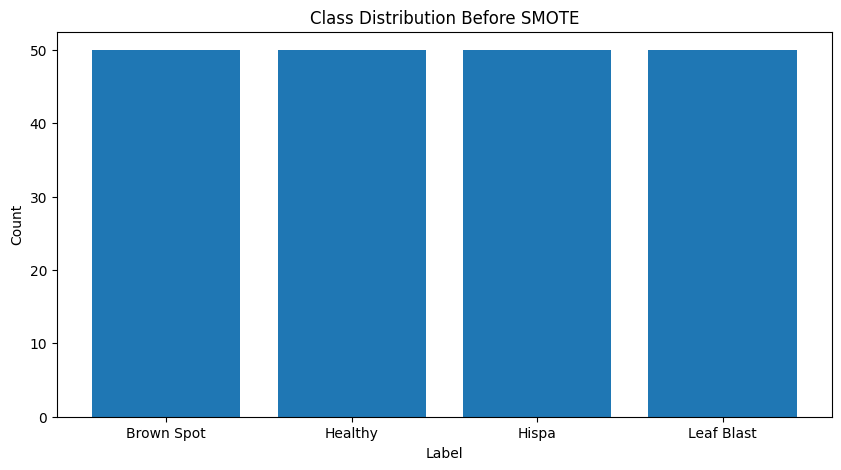

Class distribution after SMOTE:
Counter({'Brown Spot': 50, 'Healthy': 50, 'Hispa': 50, 'Leaf Blast': 50})


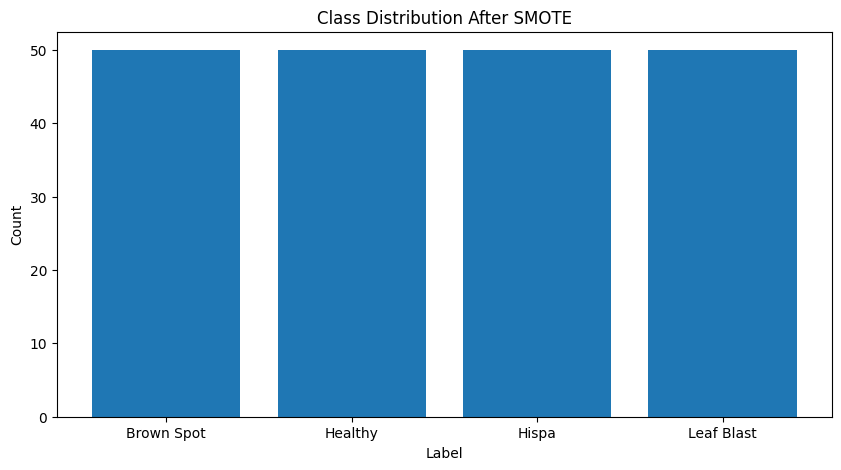

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

# Extract the features (X) and labels (y)
X = data.iloc[:, :-1]  # Select all columns except the last one as features
y = data['types']  # Select the 'types' column as the target variable

# Check the class distribution before applying SMOTE
label_counts_before = y.value_counts()
print("Class distribution before SMOTE:")
print(label_counts_before)

# Create a bar chart to visualize the class distribution before SMOTE
plt.figure(figsize=(10, 5))
plt.bar(label_counts_before.index, label_counts_before.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution Before SMOTE')
plt.show()

# Create an instance of the SMOTE class
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to balance the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the class distribution after applying SMOTE
label_counts_after = Counter(y_resampled)
print("Class distribution after SMOTE:")
print(label_counts_after)

# Create a bar chart to visualize the class distribution after SMOTE
plt.figure(figsize=(10, 5))
plt.bar(label_counts_after.keys(), label_counts_after.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution After SMOTE')
plt.show()

In [34]:
# Overwrite DataFrame with the resampled data
data = pd.DataFrame(X_resampled, columns=X.columns)
data['types'] = y_resampled

### Splitting

In [35]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,types
0,1.169881e+06,-147.769056,-426.613834,142.506609,288.855776,1.596569,38.460931,37.470086,8.274524,-6.765105,0.397298,-6.844432,-1.901315,1.106954,Brown Spot
1,-7.633874e+05,-1305.185977,249.222141,2704.278502,49.737027,-287.489953,-5.148333,-27.980625,-5.847061,1.184211,-2.820113,-4.385058,0.200137,-0.621796,Brown Spot
2,-7.854373e+05,-1459.404073,340.182716,2673.209918,8.574177,-238.851080,-0.763852,-24.743784,3.083861,6.768647,-6.300317,-4.364619,1.633860,0.475904,Brown Spot
3,4.939813e+05,-990.134482,-401.905587,-60.475911,42.041916,-29.578219,11.308001,-3.109254,13.076555,-0.097331,-4.622137,-7.576078,0.773324,0.332332,Brown Spot
4,1.193338e+05,-464.362547,349.647699,-247.326435,-59.503598,-59.292193,8.878803,-10.964161,14.853296,-5.631839,-6.252837,-7.287331,-1.595236,0.861423,Brown Spot


In [36]:
x=data.iloc[:,0:14].values

In [37]:
x

array([[ 1.16988114e+06, -1.47769056e+02, -4.26613834e+02, ...,
        -6.84443188e+00, -1.90131547e+00,  1.10695423e+00],
       [-7.63387352e+05, -1.30518598e+03,  2.49222141e+02, ...,
        -4.38505829e+00,  2.00136999e-01, -6.21796237e-01],
       [-7.85437278e+05, -1.45940407e+03,  3.40182716e+02, ...,
        -4.36461854e+00,  1.63385983e+00,  4.75903691e-01],
       ...,
       [-5.14549431e+05, -4.78264603e+02, -3.05151715e+02, ...,
        -2.86686409e+00, -1.37082036e+00, -4.63447791e-01],
       [-3.79466279e+05,  4.76350585e+02, -1.33382644e+02, ...,
        -3.01783769e+00, -8.23883614e-01, -7.77732959e-01],
       [-2.59317758e+05, -5.42959720e+02, -5.87652204e+01, ...,
         1.52017057e+01,  2.71337463e+00,  2.34828869e+00]])

In [38]:
x.shape

(200, 14)

In [39]:
y=data.iloc[:,14].values

In [40]:
y

array(['Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot',
       'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot',
       'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot',
       'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot',
       'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot',
       'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot',
       'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot',
       'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot',
       'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot',
       'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot',
       'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot',
       'Brown Spot', 'Brown Spot', 'Brown Spot', 'Brown Spot',
       'Brown Spot', 'Brown Spot', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', '

In [41]:
from sklearn.preprocessing import StandardScaler
data2=StandardScaler()
x=data2.fit_transform(x)

In [42]:
import joblib

# Save the trained model to a file
joblib.dump(data2, 'models/scalers/Rice_scaler_model.pkl')

['models/scalers/Rice_scaler_model.pkl']

In [43]:
x

array([[ 2.89421095, -0.14630258, -0.70931757, ..., -1.85813899,
        -1.49436016,  1.11734154],
       [-1.88857138, -1.29223319,  0.41437391, ..., -1.19046371,
         0.15729991, -0.62763098],
       [-1.94312148, -1.44492082,  0.56561123, ..., -1.18491469,
         1.28415041,  0.48036942],
       ...,
       [-1.27296231, -0.47351826, -0.50736628, ..., -0.77830155,
        -1.0774116 , -0.46779664],
       [-0.93877525,  0.47162324, -0.22177118, ..., -0.81928814,
        -0.64754054, -0.78503096],
       [-0.64153551, -0.53757134, -0.09770711, ...,  4.12698711,
         2.13260714,  2.37032428]])

In [44]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

### Default Parameters Training

In [45]:
from sklearn.svm import SVC

# Assuming x_train is your feature matrix and y_train is your target variable as a NumPy array
svm = SVC()

# Train the SVM model
strain = svm.fit(x_train, y_train)

In [46]:
strain

SVC()

In [47]:
import joblib

# Save the trained model to a file
joblib.dump(strain, 'models/classifiers/Rice_classifier_model.pkl')

['models/classifiers/Rice_classifier_model.pkl']

### Testing

In [48]:
x_test

array([[ 2.58186925e-01, -2.65662011e-01, -3.80810407e-02,
        -1.78899455e-01, -1.04842256e+00, -4.95257171e-01,
        -1.28850353e+00, -2.10670045e-01, -1.10514517e-01,
        -7.34822637e-01,  1.20326660e+00,  1.21999119e-01,
         5.11587654e-01, -5.98567755e-01],
       [-2.33974439e-02, -2.96884614e-01, -1.63880799e+00,
        -1.99787308e-02,  1.04605148e+00, -1.67990382e-01,
        -1.42546972e+00, -2.05016145e-01,  6.96958364e-01,
         1.07317770e+00,  3.99354231e-01, -4.56953178e-01,
         3.10134110e-01,  4.60304166e-01],
       [-4.98064354e-01,  1.09070793e+00, -1.15202638e+00,
         1.86399885e-01, -5.60455891e-01, -1.96744034e-01,
         4.82628999e-01, -2.12827482e-01,  2.08014124e-01,
         2.07232857e-01, -1.53409831e+00, -3.02608440e-01,
        -3.48572749e-01,  2.49433148e-01],
       [ 1.59657510e-01, -1.10217124e+00, -1.46804727e+00,
        -1.73403360e-02,  1.66002753e+00,  1.59501517e-01,
         8.23280986e-01, -3.31428875e-01,  3.

In [49]:
y_pred=strain.predict(x_test)

In [50]:
y_pred

array(['Brown Spot', 'Leaf Blast', 'Hispa', 'Healthy', 'Leaf Blast',
       'Leaf Blast', 'Leaf Blast', 'Hispa', 'Brown Spot', 'Leaf Blast',
       'Healthy', 'Hispa', 'Leaf Blast', 'Leaf Blast', 'Hispa',
       'Leaf Blast', 'Brown Spot', 'Hispa', 'Brown Spot', 'Healthy',
       'Brown Spot', 'Hispa', 'Brown Spot', 'Leaf Blast', 'Healthy',
       'Hispa', 'Leaf Blast', 'Leaf Blast', 'Hispa', 'Brown Spot',
       'Brown Spot', 'Healthy', 'Leaf Blast', 'Hispa', 'Brown Spot',
       'Brown Spot', 'Healthy', 'Leaf Blast', 'Hispa', 'Healthy'],
      dtype=object)

In [51]:
y_test

array(['Brown Spot', 'Leaf Blast', 'Hispa', 'Healthy', 'Leaf Blast',
       'Leaf Blast', 'Brown Spot', 'Hispa', 'Brown Spot', 'Leaf Blast',
       'Healthy', 'Hispa', 'Leaf Blast', 'Leaf Blast', 'Healthy',
       'Brown Spot', 'Brown Spot', 'Hispa', 'Brown Spot', 'Healthy',
       'Leaf Blast', 'Hispa', 'Brown Spot', 'Leaf Blast', 'Healthy',
       'Hispa', 'Leaf Blast', 'Leaf Blast', 'Hispa', 'Brown Spot',
       'Brown Spot', 'Healthy', 'Leaf Blast', 'Hispa', 'Brown Spot',
       'Leaf Blast', 'Hispa', 'Brown Spot', 'Healthy', 'Hispa'],
      dtype=object)

In [52]:
print("Number of Training Data:", len(y_train))
print("Number of Testing Data:", len(y_test))

Number of Training Data: 160
Number of Testing Data: 40


In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[ 8,  0,  0,  3],
       [ 0,  5,  2,  0],
       [ 0,  2,  8,  0],
       [ 2,  0,  0, 10]], dtype=int64)

In [54]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.775

### Testing Models

In [ ]:
main_img = cv2.imread('dataset/images/Cedar apple rust/0cd24b0c-0a9d-483f-8734-5c08988e029f___FREC_C.Rust 3762.jpg')

names = ['area', 'perimeter', 'physiological_length', 'physiological_width', 'aspect_ratio',
             'mean_r', 'mean_g', 'mean_b', 'stddev_r', 'stddev_g', 'stddev_b',
             'contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity',
             'eccentricity', 'solidity', 'equiv_diameter', 'major_axis_length', 'minor_axis_length',
             'skewness', 'kurtosis', 'hog_feature_1', 'hog_feature_2', 'hog_feature_3'
            ]
df = pd.DataFrame(columns=names)

# Preprocessing
img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gs, (25, 25), 0)
ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((50, 50), np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# Shape features
contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
area = cv2.contourArea(cnt)
perimeter = cv2.arcLength(cnt, True)
x, y, w, h = cv2.boundingRect(cnt)
aspect_ratio = float(w) / h

# Color features
red_channel = img[:, :, 0]
green_channel = img[:, :, 1]
blue_channel = img[:, :, 2]

red_mean = np.mean(red_channel)
green_mean = np.mean(green_channel)
blue_mean = np.mean(blue_channel)

# Std deviation
red_std = np.std(red_channel)
green_std = np.std(green_channel)
blue_std = np.std(blue_channel)

# Texture features using GLCM matrix
glcm = graycomatrix(gs,
                distances=[1],
                angles=[0],
                symmetric=True,
                normed=True)

properties = ['contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity']
contrast = graycoprops(glcm, properties[0])
energy = graycoprops(glcm, properties[1])
homogeneity = graycoprops(glcm, properties[2])
correlation = graycoprops(glcm, properties[3])
dissimilarity = graycoprops(glcm, properties[4])

# Statistical moments
skewness = stats.skew(gs.flatten())
kurtosis = stats.kurtosis(gs.flatten())

# Additional features
labeled_img = label(closing)
regions = regionprops(labeled_img)

eccentricity = regions[0].eccentricity
solidity = regions[0].solidity
equiv_diameter = regions[0].equivalent_diameter
major_axis_length = regions[0].major_axis_length
minor_axis_length = regions[0].minor_axis_length

# HOG features
hog_features = hog(gs, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2-Hys')

vector = [area, perimeter, w, h, aspect_ratio,
        red_mean, green_mean, blue_mean, red_std, green_std, blue_std,
        contrast[0][0], energy[0][0], homogeneity[0][0], correlation[0][0], dissimilarity[0][0],
        eccentricity, solidity, equiv_diameter, major_axis_length, minor_axis_length,
        skewness, kurtosis, hog_features[0], hog_features[1], hog_features[2]]

df_temp = pd.DataFrame([vector], columns=names)
df = pd.concat([df, df_temp], ignore_index=True)

pca_model = joblib.load('models/pca/Apple_pca_model.pkl')
pca = pca_model.transform(df)

scaler_model = joblib.load('models/scalers/Apple_scaler_model.pkl')
scaled = scaler_model.transform(pca)

classifier_model = joblib.load('models/classifiers/Apple_classifier_model.pkl')
results = classifier_model.predict(scaled)

print('FEATURES', df)
print('PCA', pca)
print('SCALED', scaled)
print('RESULTS', results)

### Checking

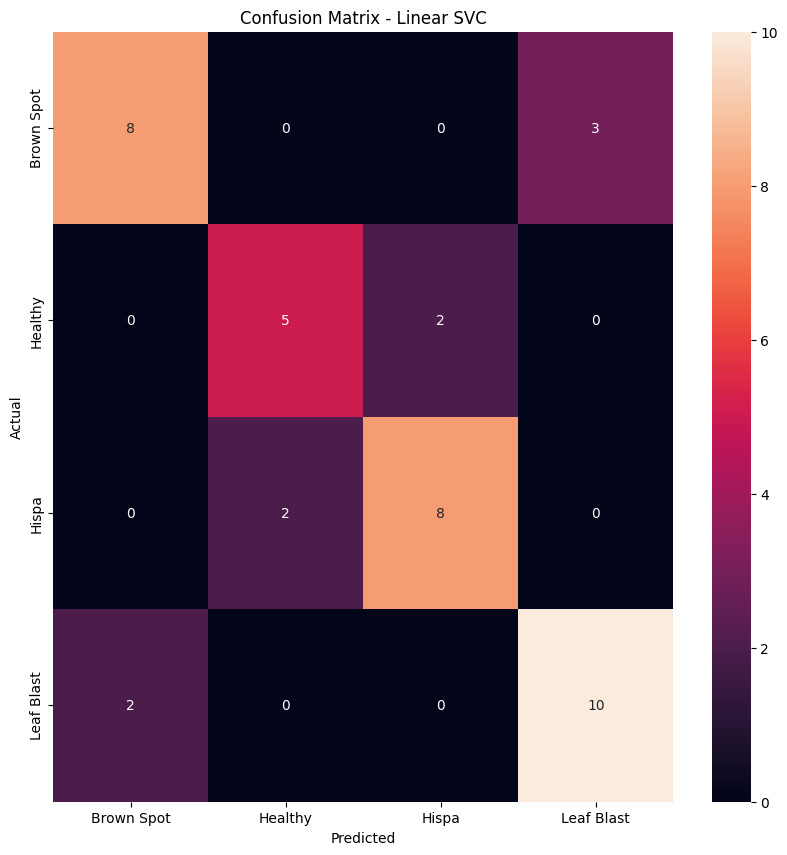

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'y_test' contains the true labels and 'y_pred' contains the predicted labels
conf_mat = confusion_matrix(y_test, y_pred, labels=data['types'].unique())

# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=data['types'].unique(),
            yticklabels=data['types'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix - Linear SVC")
plt.show()

In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have true labels (y_true) and predicted labels (y_pred)
y_true = y_test
y_pred = y_pred

data=pd.read_csv("dataset/csv/image_features.csv")
types = data["types"]
types_labels = types.unique()

# Compute precision, recall, and F1-score for each class
classes =  types_labels

precision = precision_score(y_true, y_pred, labels=classes, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, labels=classes, average=None, zero_division=0)
f1 = f1_score(y_true, y_pred, labels=classes, average=None, zero_division=0)

# Display the results for each class
for class_label, p, r, f in zip(classes, precision, recall, f1):
    print(f"Class {class_label} - Precision: {p} \n\t\t  Recall: {r} \n\t\t  F1-Score: {f}\n")

Class Brown Spot - Precision: 0.8 
		  Recall: 0.7272727272727273 
		  F1-Score: 0.761904761904762

Class Healthy - Precision: 0.7142857142857143 
		  Recall: 0.7142857142857143 
		  F1-Score: 0.7142857142857143

Class Hispa - Precision: 0.8 
		  Recall: 0.8 
		  F1-Score: 0.8000000000000002

Class Leaf Blast - Precision: 0.7692307692307693 
		  Recall: 0.8333333333333334 
		  F1-Score: 0.8



## Grid Search

In [57]:
import threading
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pandas as pd

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types
    'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1, 10]  # Kernel coefficient (only for 'rbf', 'poly', 'sigmoid')
}

# Create an SVM model
svm = SVC()

# Create a GridSearchCV object with the SVM model and parameter grid
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

# Initialize a variable to keep track of the number of combinations
total_combinations = len(param_grid['C']) * len(param_grid['kernel']) * len(param_grid['gamma'])
combination_count = 0

# Create an empty list to store the results
results = []

# Lock for thread synchronization
results_lock = threading.Lock()

# Function to train the SVM model with a timeout
def train_svm_with_timeout(C, kernel, gamma, result_flag):
    try:
        svm = SVC(C=C, kernel=kernel, gamma=gamma)
        svm.fit(x_train, y_train)
        y_pred = svm.predict(x_test)  # Predict on the test data
        accuracy = (y_pred == y_test).mean()  # Calculate accuracy
        with results_lock:
            results.append([C, kernel, gamma, accuracy])
        result_flag[0] = True
    except Exception as e:
        result_flag[0] = False

# Fit the grid search to your training data
for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        for gamma in param_grid['gamma']:
            combination_count += 1
            print(f"Combination {combination_count}/{total_combinations}: C={C}, kernel={kernel}, gamma={gamma}")

            result_flag = [False]

            t = threading.Thread(target=train_svm_with_timeout, args=(C, kernel, gamma, result_flag))
            t.start()
            t.join(timeout=300)  # Adjust the timeout value as needed

            if result_flag[0]:
                print("Accuracy on test data: ", results[-1][-1])
            else:
                print("Training took too long or encountered an error. Skipping to the next combination.")

# Create a DataFrame from the results
result_df = pd.DataFrame(results, columns=["C", "Kernel", "Gamma", "Accuracy"])

# Save the DataFrame to a CSV file
output_csv = r"dataset/csv/grid_search_results.csv"
result_df.to_csv(output_csv, index=False)

Combination 1/112: C=0.1, kernel=linear, gamma=scale
Accuracy on test data:  0.775
Combination 2/112: C=0.1, kernel=linear, gamma=auto
Accuracy on test data:  0.775
Combination 3/112: C=0.1, kernel=linear, gamma=0.001
Accuracy on test data:  0.775
Combination 4/112: C=0.1, kernel=linear, gamma=0.01
Accuracy on test data:  0.775
Combination 5/112: C=0.1, kernel=linear, gamma=0.1
Accuracy on test data:  0.775
Combination 6/112: C=0.1, kernel=linear, gamma=1
Accuracy on test data:  0.775
Combination 7/112: C=0.1, kernel=linear, gamma=10
Accuracy on test data:  0.775
Combination 8/112: C=0.1, kernel=rbf, gamma=scale
Accuracy on test data:  0.275
Combination 9/112: C=0.1, kernel=rbf, gamma=auto
Accuracy on test data:  0.275
Combination 10/112: C=0.1, kernel=rbf, gamma=0.001
Accuracy on test data:  0.175
Combination 11/112: C=0.1, kernel=rbf, gamma=0.01
Accuracy on test data:  0.175
Combination 12/112: C=0.1, kernel=rbf, gamma=0.1
Accuracy on test data:  0.25
Combination 13/112: C=0.1, kerne

### Grid Search Training

In [58]:
import pandas as pd
grid_df=pd.read_csv("dataset/csv/grid_search_results.csv")

In [59]:
len(grid_df)

112

In [60]:
grid_df.head()

,C,Kernel,Gamma,Accuracy
0,0.1,linear,scale,0.775
1,0.1,linear,auto,0.775
2,0.1,linear,0.001,0.775
3,0.1,linear,0.01,0.775
4,0.1,linear,0.1,0.775


In [61]:
# Find the index of the row with the highest accuracy
max_accuracy_index = grid_df['Accuracy'].idxmax()

# Get the row with the highest accuracy
row_with_highest_accuracy = grid_df.loc[max_accuracy_index]

print(row_with_highest_accuracy)

C            10.0
Kernel        rbf
Gamma       scale
Accuracy     0.85
Name: 63, dtype: object


In [62]:
from sklearn.svm import SVC

# Specify the parameters
C = float(row_with_highest_accuracy.C)
kernel = row_with_highest_accuracy.Kernel
gamma_value = row_with_highest_accuracy.Gamma

if isinstance(gamma_value, str):
    gamma = gamma_value
elif isinstance(gamma_value, (int,float)):
    gamma = gamma_value
else:
    raise ValueError("Invalid gamma value")

# Create an SVC with the specified parameters
svm = SVC(C=C, kernel=kernel, gamma=gamma)

# Train the model on your training data
train_grid = svm.fit(x_train, y_train)

In [63]:
train_grid

SVC(C=10.0)

In [64]:
import joblib

# Save the trained model to a file
joblib.dump(train_grid, 'models/classifiers/Rice_classifier_model.pkl')

['models/classifiers/Rice_classifier_model.pkl']

In [65]:
y_pred=train_grid.predict(x_test)

In [66]:
y_pred

array(['Brown Spot', 'Leaf Blast', 'Hispa', 'Healthy', 'Leaf Blast',
       'Leaf Blast', 'Leaf Blast', 'Hispa', 'Brown Spot', 'Leaf Blast',
       'Healthy', 'Hispa', 'Leaf Blast', 'Leaf Blast', 'Healthy',
       'Leaf Blast', 'Brown Spot', 'Healthy', 'Brown Spot', 'Healthy',
       'Leaf Blast', 'Hispa', 'Brown Spot', 'Leaf Blast', 'Healthy',
       'Hispa', 'Leaf Blast', 'Leaf Blast', 'Hispa', 'Brown Spot',
       'Brown Spot', 'Healthy', 'Leaf Blast', 'Hispa', 'Brown Spot',
       'Leaf Blast', 'Hispa', 'Leaf Blast', 'Hispa', 'Healthy'],
      dtype=object)

In [67]:
y_test

array(['Brown Spot', 'Leaf Blast', 'Hispa', 'Healthy', 'Leaf Blast',
       'Leaf Blast', 'Brown Spot', 'Hispa', 'Brown Spot', 'Leaf Blast',
       'Healthy', 'Hispa', 'Leaf Blast', 'Leaf Blast', 'Healthy',
       'Brown Spot', 'Brown Spot', 'Hispa', 'Brown Spot', 'Healthy',
       'Leaf Blast', 'Hispa', 'Brown Spot', 'Leaf Blast', 'Healthy',
       'Hispa', 'Leaf Blast', 'Leaf Blast', 'Hispa', 'Brown Spot',
       'Brown Spot', 'Healthy', 'Leaf Blast', 'Hispa', 'Brown Spot',
       'Leaf Blast', 'Hispa', 'Brown Spot', 'Healthy', 'Hispa'],
      dtype=object)

In [68]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.85

### Grid Search Checking

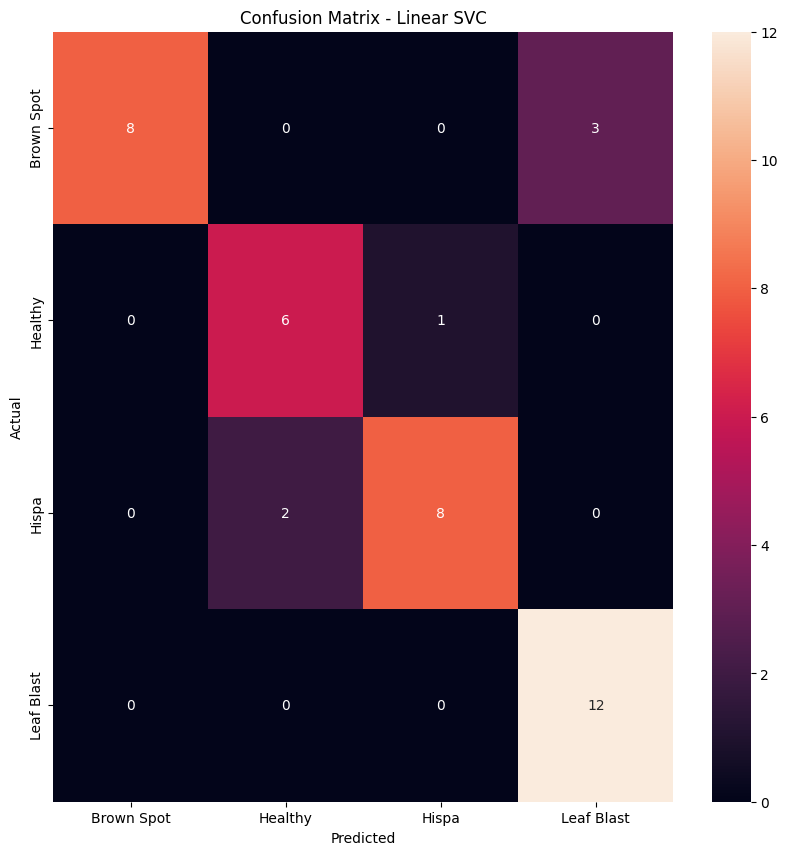

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'y_test' contains the true labels and 'y_pred' contains the predicted labels
conf_mat = confusion_matrix(y_test, y_pred, labels=data['types'].unique())

# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=data['types'].unique(),
            yticklabels=data['types'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix - Linear SVC")
plt.show()

In [70]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have true labels (y_true) and predicted labels (y_pred)
y_true = y_test
y_pred = y_pred

data=pd.read_csv("dataset/csv/image_features.csv")
types = data["types"]
types_labels = types.unique()

# Compute precision, recall, and F1-score for each class
classes = types_labels

precision = precision_score(y_true, y_pred, labels=classes, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, labels=classes, average=None, zero_division=0)
f1 = f1_score(y_true, y_pred, labels=classes, average=None, zero_division=0)

# Display the results for each class
for class_label, p, r, f in zip(classes, precision, recall, f1):
    print(f"Class {class_label} - Precision: {p} \n\t\t  Recall: {r} \n\t\t  F1-Score: {f}\n")

Class Brown Spot - Precision: 1.0 
		  Recall: 0.7272727272727273 
		  F1-Score: 0.8421052631578948

Class Healthy - Precision: 0.75 
		  Recall: 0.8571428571428571 
		  F1-Score: 0.7999999999999999

Class Hispa - Precision: 0.8888888888888888 
		  Recall: 0.8 
		  F1-Score: 0.8421052631578948

Class Leaf Blast - Precision: 0.8 
		  Recall: 1.0 
		  F1-Score: 0.888888888888889

